In [ ]:
!pip install torch torchvision transformers datasets huggingface_hub opencv-python matplotlib tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!echo '{"username":"aritraoreo","key":"95aecea54e1d1dd30d7af8f683e88778"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
!unzip lgg-mri-segmentation.zip -d LGG_Dataset

Streaming output truncated to the last 5000 lines.
  inflating: LGG_Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: LGG_Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: LGG_Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: LGG_Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: LGG_Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: LGG_Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: LGG_Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: LGG_Dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: LGG_Dataset/lgg-mri-segmentation/kaggle_3m/TCG

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import cv2
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

In [ ]:
class BrainTumorDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.cvtColor(cv2.imread(self.image_paths[idx]), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], 0)
        mask = (mask > 0).astype(np.float32)  # Ensure binary mask

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0)

In [ ]:
def get_transforms(img_size=256):
    train_transform = A.Compose([
        A.Resize(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

    return train_transform, val_transform

In [ ]:
def create_model():
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        num_labels=1,
        ignore_mismatched_sizes=True,
    )

    # Custom head for binary segmentation
    model.decode_head.classifier = nn.Sequential(
        nn.Conv2d(256, 128, kernel_size=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128, 1, kernel_size=1)
    )

    return model

In [ ]:
class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(
            inputs, targets,
            reduction='none'
        )

        p_t = torch.exp(-bce_loss)
        focal_loss = (self.alpha * (1-p_t)**self.gamma * bce_loss).mean()

        # Dice loss
        inputs = torch.sigmoid(inputs)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + 1e-6) / (inputs.sum() + targets.sum() + 1e-6)

        return focal_loss + dice_loss

def calculate_iou(preds, targets):
    preds = (torch.sigmoid(preds) > 0.5).float()
    intersection = (preds * targets).sum()
    union = (preds + targets).sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

In [ ]:
def calculate_iou(preds, targets):
    preds = (torch.sigmoid(preds) > 0.5).float()
    intersection = (preds * targets).sum()
    union = (preds + targets).sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

In [ ]:
def train_model(model, train_loader, val_loader, epochs=20, lr=3e-5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
    criterion = FocalDiceLoss(alpha=0.8)

    best_iou = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, masks = images.to(device), masks.to(device)

            outputs = model(pixel_values=images).logits
            outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            train_loss += loss.item()


        model.eval()
        val_iou = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(pixel_values=images).logits
                outputs = F.interpolate(outputs, size=masks.shape[-2:], mode='bilinear', align_corners=False)
                val_iou += calculate_iou(outputs, masks).item()

        val_iou /= len(val_loader)
        train_loss /= len(train_loader)

        scheduler.step(val_iou)

        print(f"Epoch {epoch+1}: Loss={train_loss:.4f}, IoU={val_iou:.4f}, LR={optimizer.param_groups[0]['lr']:.2e}")

        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved new best model")


In [ ]:
def visualize_predictions(model, dataset, device='cuda', n_samples=3):
    model.eval()
    indices = np.random.choice(len(dataset), n_samples)

    plt.figure(figsize=(15, 5*n_samples))
    for i, idx in enumerate(indices):
        image, mask = dataset[idx]
        with torch.no_grad():
            pred = model(pixel_values=image.unsqueeze(0).to(device)).logits
            pred = torch.sigmoid(pred).squeeze().cpu().numpy()

        plt.subplot(n_samples, 3, i*3+1)
        plt.imshow(image.permute(1,2,0).cpu().numpy())
        plt.title("Input")
        plt.axis('off')

        plt.subplot(n_samples, 3, i*3+2)
        plt.imshow(mask.squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        plt.subplot(n_samples, 3, i*3+3)
        plt.imshow(pred > 0.5, cmap='gray')
        plt.title("Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([1, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/20: 100%|██████████| 786/786 [00:44<00:00, 17.70it/s]


Epoch 1: Loss=0.9914, IoU=0.5475, LR=3.00e-05
Saved new best model


Epoch 2/20: 100%|██████████| 786/786 [00:43<00:00, 17.95it/s]


Epoch 2: Loss=0.8711, IoU=0.6403, LR=3.00e-05
Saved new best model


Epoch 3/20: 100%|██████████| 786/786 [00:43<00:00, 18.06it/s]


Epoch 3: Loss=0.7303, IoU=0.7046, LR=3.00e-05
Saved new best model


Epoch 4/20: 100%|██████████| 786/786 [00:43<00:00, 17.89it/s]


Epoch 4: Loss=0.5791, IoU=0.7362, LR=3.00e-05
Saved new best model


Epoch 5/20: 100%|██████████| 786/786 [00:43<00:00, 18.13it/s]


Epoch 5: Loss=0.4647, IoU=0.7232, LR=3.00e-05


Epoch 6/20: 100%|██████████| 786/786 [00:43<00:00, 17.96it/s]


Epoch 6: Loss=0.4037, IoU=0.7521, LR=3.00e-05
Saved new best model


Epoch 7/20: 100%|██████████| 786/786 [00:43<00:00, 17.96it/s]


Epoch 7: Loss=0.3535, IoU=0.7454, LR=3.00e-05


Epoch 8/20: 100%|██████████| 786/786 [00:44<00:00, 17.82it/s]


Epoch 8: Loss=0.3416, IoU=0.7601, LR=3.00e-05
Saved new best model


Epoch 9/20: 100%|██████████| 786/786 [00:43<00:00, 17.96it/s]


Epoch 9: Loss=0.3116, IoU=0.7451, LR=3.00e-05


Epoch 10/20: 100%|██████████| 786/786 [00:43<00:00, 17.98it/s]


Epoch 10: Loss=0.3203, IoU=0.7703, LR=3.00e-05
Saved new best model


Epoch 11/20: 100%|██████████| 786/786 [00:43<00:00, 18.20it/s]


Epoch 11: Loss=0.3145, IoU=0.7681, LR=3.00e-05


Epoch 12/20: 100%|██████████| 786/786 [00:43<00:00, 18.00it/s]


Epoch 12: Loss=0.3057, IoU=0.7685, LR=3.00e-05


Epoch 13/20: 100%|██████████| 786/786 [00:43<00:00, 17.87it/s]


Epoch 13: Loss=0.3003, IoU=0.7612, LR=3.00e-06


Epoch 14/20: 100%|██████████| 786/786 [00:45<00:00, 17.40it/s]


Epoch 14: Loss=0.3045, IoU=0.7699, LR=3.00e-06


Epoch 15/20: 100%|██████████| 786/786 [00:44<00:00, 17.86it/s]


Epoch 15: Loss=0.2952, IoU=0.7682, LR=3.00e-06


Epoch 16/20: 100%|██████████| 786/786 [00:44<00:00, 17.59it/s]


Epoch 16: Loss=0.3037, IoU=0.7708, LR=3.00e-06
Saved new best model


Epoch 17/20: 100%|██████████| 786/786 [00:43<00:00, 17.88it/s]


Epoch 17: Loss=0.2866, IoU=0.7713, LR=3.00e-06
Saved new best model


Epoch 18/20: 100%|██████████| 786/786 [00:44<00:00, 17.69it/s]


Epoch 18: Loss=0.2941, IoU=0.7699, LR=3.00e-06


Epoch 19/20: 100%|██████████| 786/786 [00:43<00:00, 17.95it/s]


Epoch 19: Loss=0.2958, IoU=0.7713, LR=3.00e-06
Saved new best model


Epoch 20/20: 100%|██████████| 786/786 [00:43<00:00, 17.99it/s]


Epoch 20: Loss=0.2934, IoU=0.7699, LR=3.00e-07


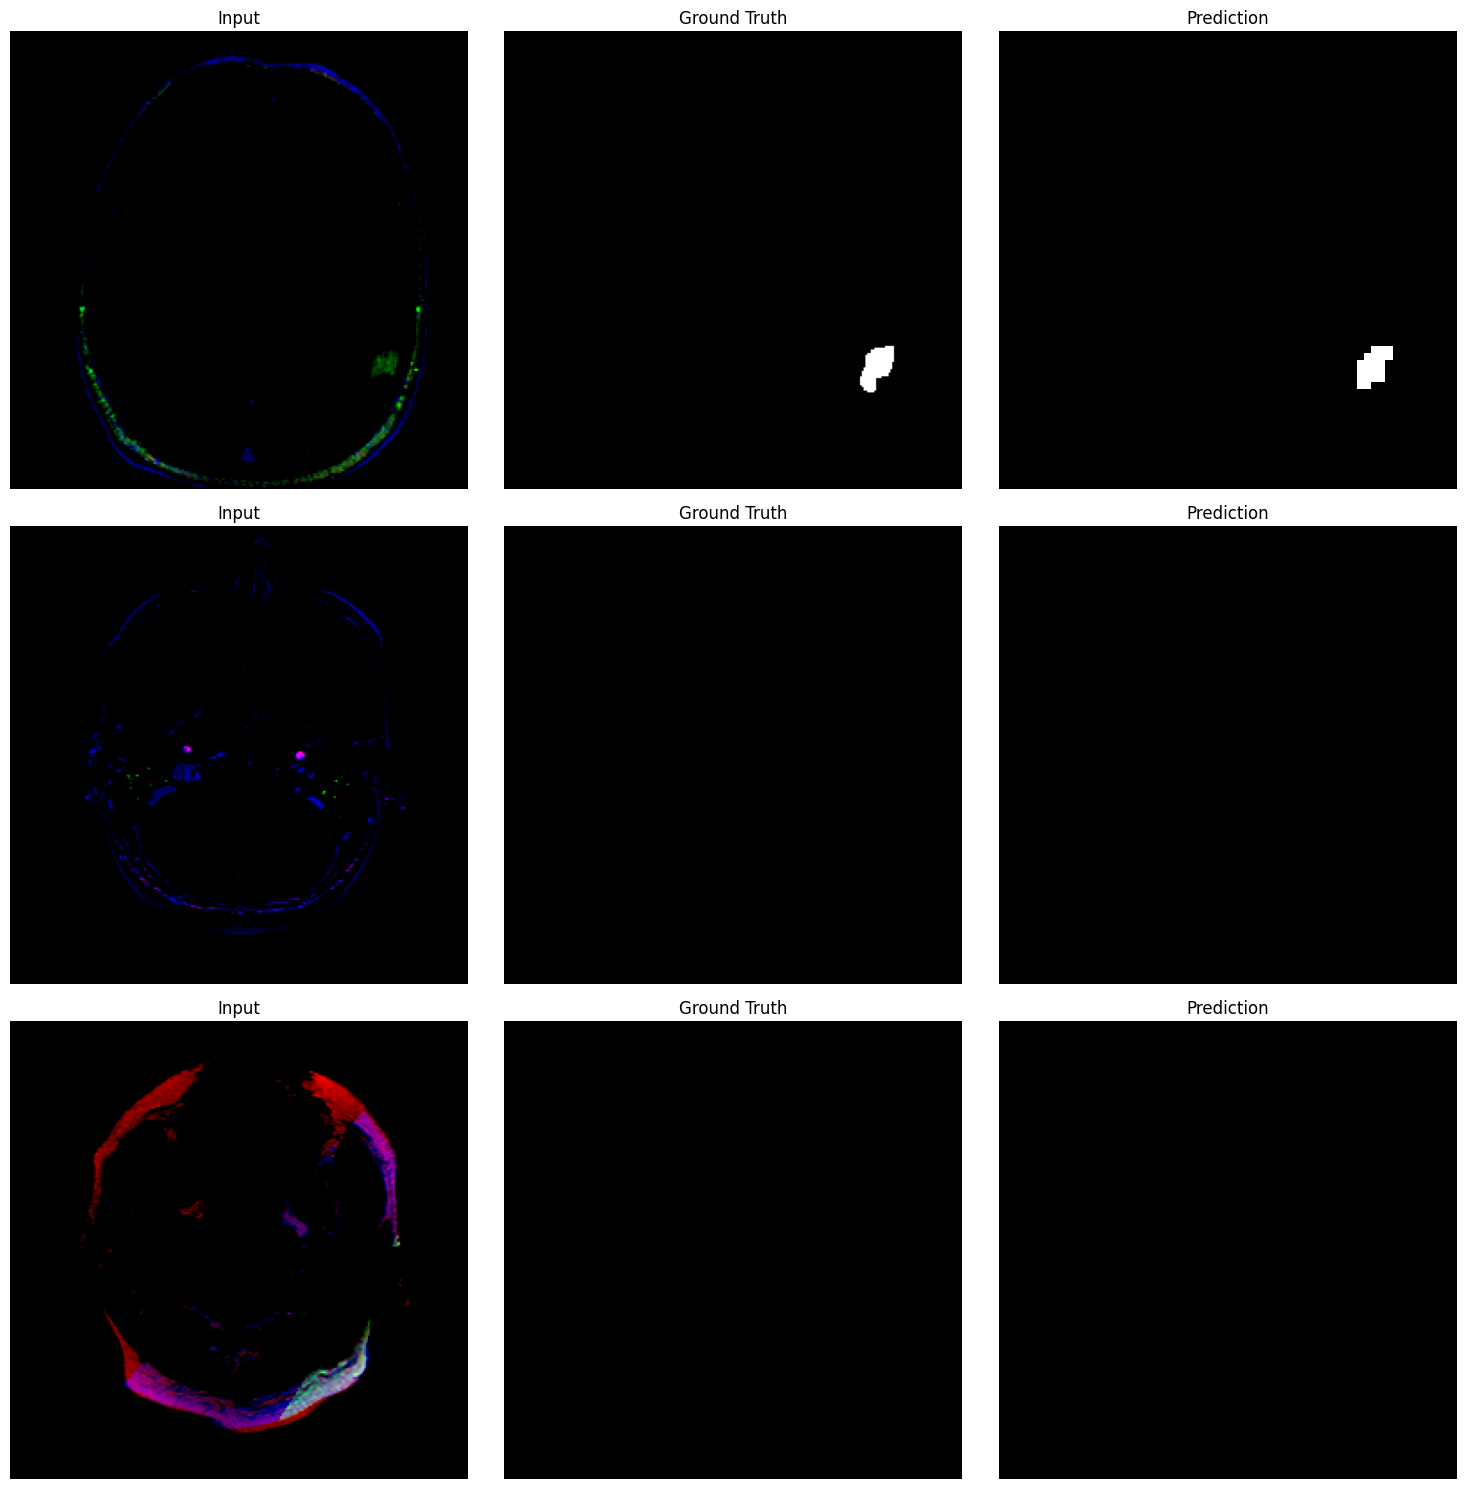

In [ ]:
if __name__ == "__main__":
    # Match image-mask pairs properly
    all_masks = sorted(glob('/content/LGG_Dataset/kaggle_3m/*/*_mask.tif'))
    all_images = [path.replace('_mask', '') for path in all_masks]  # corresponding image path

    assert len(all_images) == len(all_masks), "Mismatch between images and masks"

    train_img, val_img, train_mask, val_mask = train_test_split(
        all_images, all_masks, test_size=0.2, random_state=42
    )

    train_transform, val_transform = get_transforms(img_size=256)
    train_dataset = BrainTumorDataset(train_img, train_mask, train_transform)
    val_dataset = BrainTumorDataset(val_img, val_mask, val_transform)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

    model = create_model()
    train_model(model, train_loader, val_loader, epochs=20)

    model.load_state_dict(torch.load('best_model.pth'))
    visualize_predictions(model, val_dataset)
